### Building an image classification model using very little data  

Based on the tutorial by Francois Chollet @fchollet https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html and the workbook by Guillaume Dominici https://github.com/gggdominici/keras-workshop

This tutorial presents several ways to build an image classifier using keras from just a few hundred or thousand pictures from each class you want to be able to recognize.

We will go over the following options:  

- training a small network from scratch (as a baseline)  
- using the bottleneck features of a pre-trained network  
- fine-tuning the top layers of a pre-trained network  
  
This will lead us to cover the following Keras features:   
  
- fit_generator for training Keras a model using Python data generators  
- ImageDataGenerator for real-time data augmentation  
- layer freezing and model fine-tuning  
- ...and more.  


## Data

Data can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data  
All you need is the train set  
The recommended folder structure is:  

### Folder structure

```python
data/
    train/
        dogs/ ### 1024 pictures
            dog001.jpg
            dog002.jpg
            ...
        cats/ ### 1024 pictures
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/ ### 416 pictures
            dog001.jpg
            dog002.jpg
            ...
        cats/ ### 416 pictures
            cat001.jpg
            cat002.jpg
            ...
```
Note : for this example we only consider 2x1000 training images and 2x400 testing images among the 2x12500 available.

The github repo includes about 1500 images for this model. The original Kaggle dataset is much larger. The purpose of this demo is to show how you can build models with smaller size datasets. You should be able to improve this model by using more data.

### Data loading

In [2]:
##This notebook is built around using tensorflow as the backend for keras
!pip install pillow
!KERAS_BACKEND=tensorflow python -c "from keras import backend"

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Using TensorFlow backend.
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcublas.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcudnn.so.5 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcufft.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcurand.so.8.0 locally


In [3]:
##Updated to Keras 2.0
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [ ]:
#using Tensorboard
#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
#!nohup tensorboard --logdir=/root/sharedfolder/Data1/Code/image_keras/logs

In [ ]:
#Keras settings
#keras.__version__
#!cat ~/.keras/keras.json

### Data Loading

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

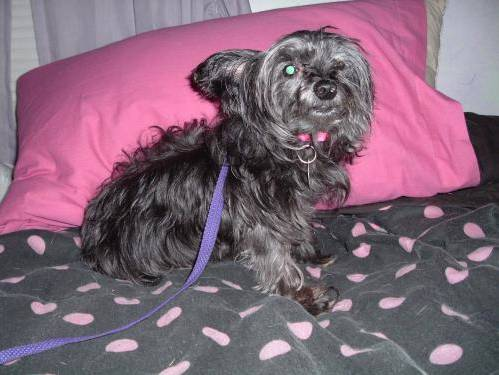

In [3]:
Image(filename='data/train/dogs/dog.0.jpg') 

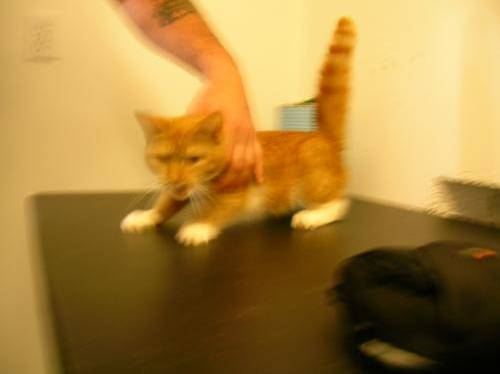

In [4]:
Image(filename='data/train/cats/cat.0.jpg') 

### Imports

In [6]:
##preprocessing
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2048 images belonging to 2 classes.
Found 832 images belonging to 2 classes.


In [10]:
##Lets look at the training data from the datagenerator
i = 0
for batch in datagen.flow_from_directory(train_data_dir,
        target_size=(img_width, img_height),
        class_mode='binary',batch_size=1,
                          save_to_dir='preview', save_prefix='train', save_format='jpg'):
    i += 1
    if i > 20:
        break  #

Found 2048 images belonging to 2 classes.


In [11]:
!ls preview

aug2_0_125.jpg	   train_12_1168.jpg  train_17_5031.jpg  train_4_3297.jpg
aug2_0_1805.jpg    train_12_9061.jpg  train_1_75.jpg	 train_4_3753.jpg
aug2_0_2253.jpg    train_13_3936.jpg  train_18_8046.jpg  train_5_2054.jpg
aug2_0_3107.jpg    train_13_737.jpg   train_18_8431.jpg  train_5_6591.jpg
aug2_0_4003.jpg    train_14_3427.jpg  train_19_6181.jpg  train_6_6153.jpg
aug2_0_7307.jpg    train_14_7598.jpg  train_19_9408.jpg  train_6_8550.jpg
train_0_5372.jpg   train_15_3216.jpg  train_20_7450.jpg  train_7_6307.jpg
train_0_7289.jpg   train_15_5589.jpg  train_20_7602.jpg  train_7_8120.jpg
train_10_2638.jpg  train_16_172.jpg   train_2_1654.jpg	 train_8_2649.jpg
train_10_3001.jpg  train_16_3743.jpg  train_2_8433.jpg	 train_8_3558.jpg
train_11_4831.jpg  train_1_6767.jpg   train_3_2508.jpg	 train_9_3911.jpg
train_11_6773.jpg  train_17_2432.jpg  train_3_3853.jpg	 train_9_5143.jpg


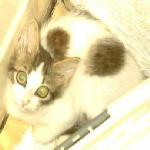

In [13]:
Image(filename='preview/train_12_1168.jpg') 

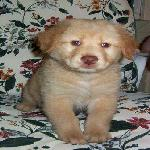

In [14]:
Image(filename='preview/train_9_5143.jpg') 

## Small Conv Net

### Model architecture definition

In [3]:
# a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers.
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Training

In [7]:
epochs = 30
train_samples = 2048
validation_samples = 832

In [8]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples// batch_size,)
#About 60 seconds an epoch when using CPU

Epoch 1/30
64/64 [==============================] - 61s - loss: 0.7004 - acc: 0.5205 - val_loss: 0.6861 - val_acc: 0.5288
Epoch 2/30
64/64 [==============================] - 3s - loss: 0.6668 - acc: 0.6177 - val_loss: 0.6322 - val_acc: 0.6430
Epoch 3/30
64/64 [==============================] - 3s - loss: 0.6260 - acc: 0.6621 - val_loss: 0.6390 - val_acc: 0.6454
Epoch 4/30
64/64 [==============================] - 3s - loss: 0.5847 - acc: 0.7075 - val_loss: 0.5782 - val_acc: 0.6731
Epoch 5/30
64/64 [==============================] - 3s - loss: 0.5446 - acc: 0.7271 - val_loss: 0.6108 - val_acc: 0.6454
Epoch 6/30
64/64 [==============================] - 3s - loss: 0.5141 - acc: 0.7500 - val_loss: 0.5884 - val_acc: 0.6755
Epoch 7/30
64/64 [==============================] - 3s - loss: 0.4930 - acc: 0.7764 - val_loss: 0.5914 - val_acc: 0.6959
Epoch 8/30
64/64 [==============================] - 3s - loss: 0.4424 - acc: 0.7822 - val_loss: 0.6365 - val_acc: 0.7091
Epoch 9/30
64/64 [=============

In [9]:
model.save_weights('models/basic_cnn_30_epochs.h5')

In [4]:
#model.save_weights('models_trained/basic_cnn_30_epochs.h5')
model.load_weights('models_trained/basic_cnn_30_epochs.h5')

If your model successfully runs at one epoch, go back and it for 30 epochs by changing nb_epoch above.  I was able to get to an val_acc of 0.71 at 30 epochs.
A copy of a pretrained network is available in the pretrained folder.

### Validating the Model's Performance

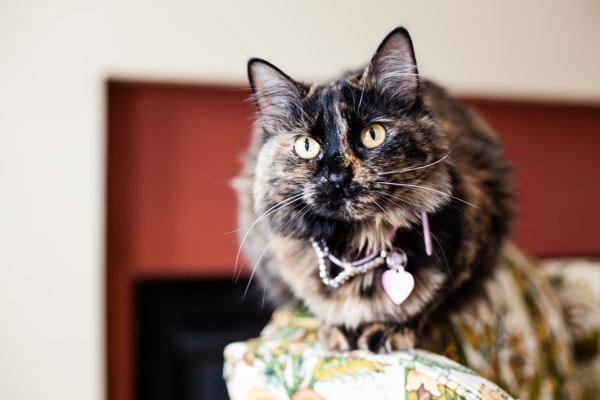

In [15]:
Image(filename='raj/alice.jpg')

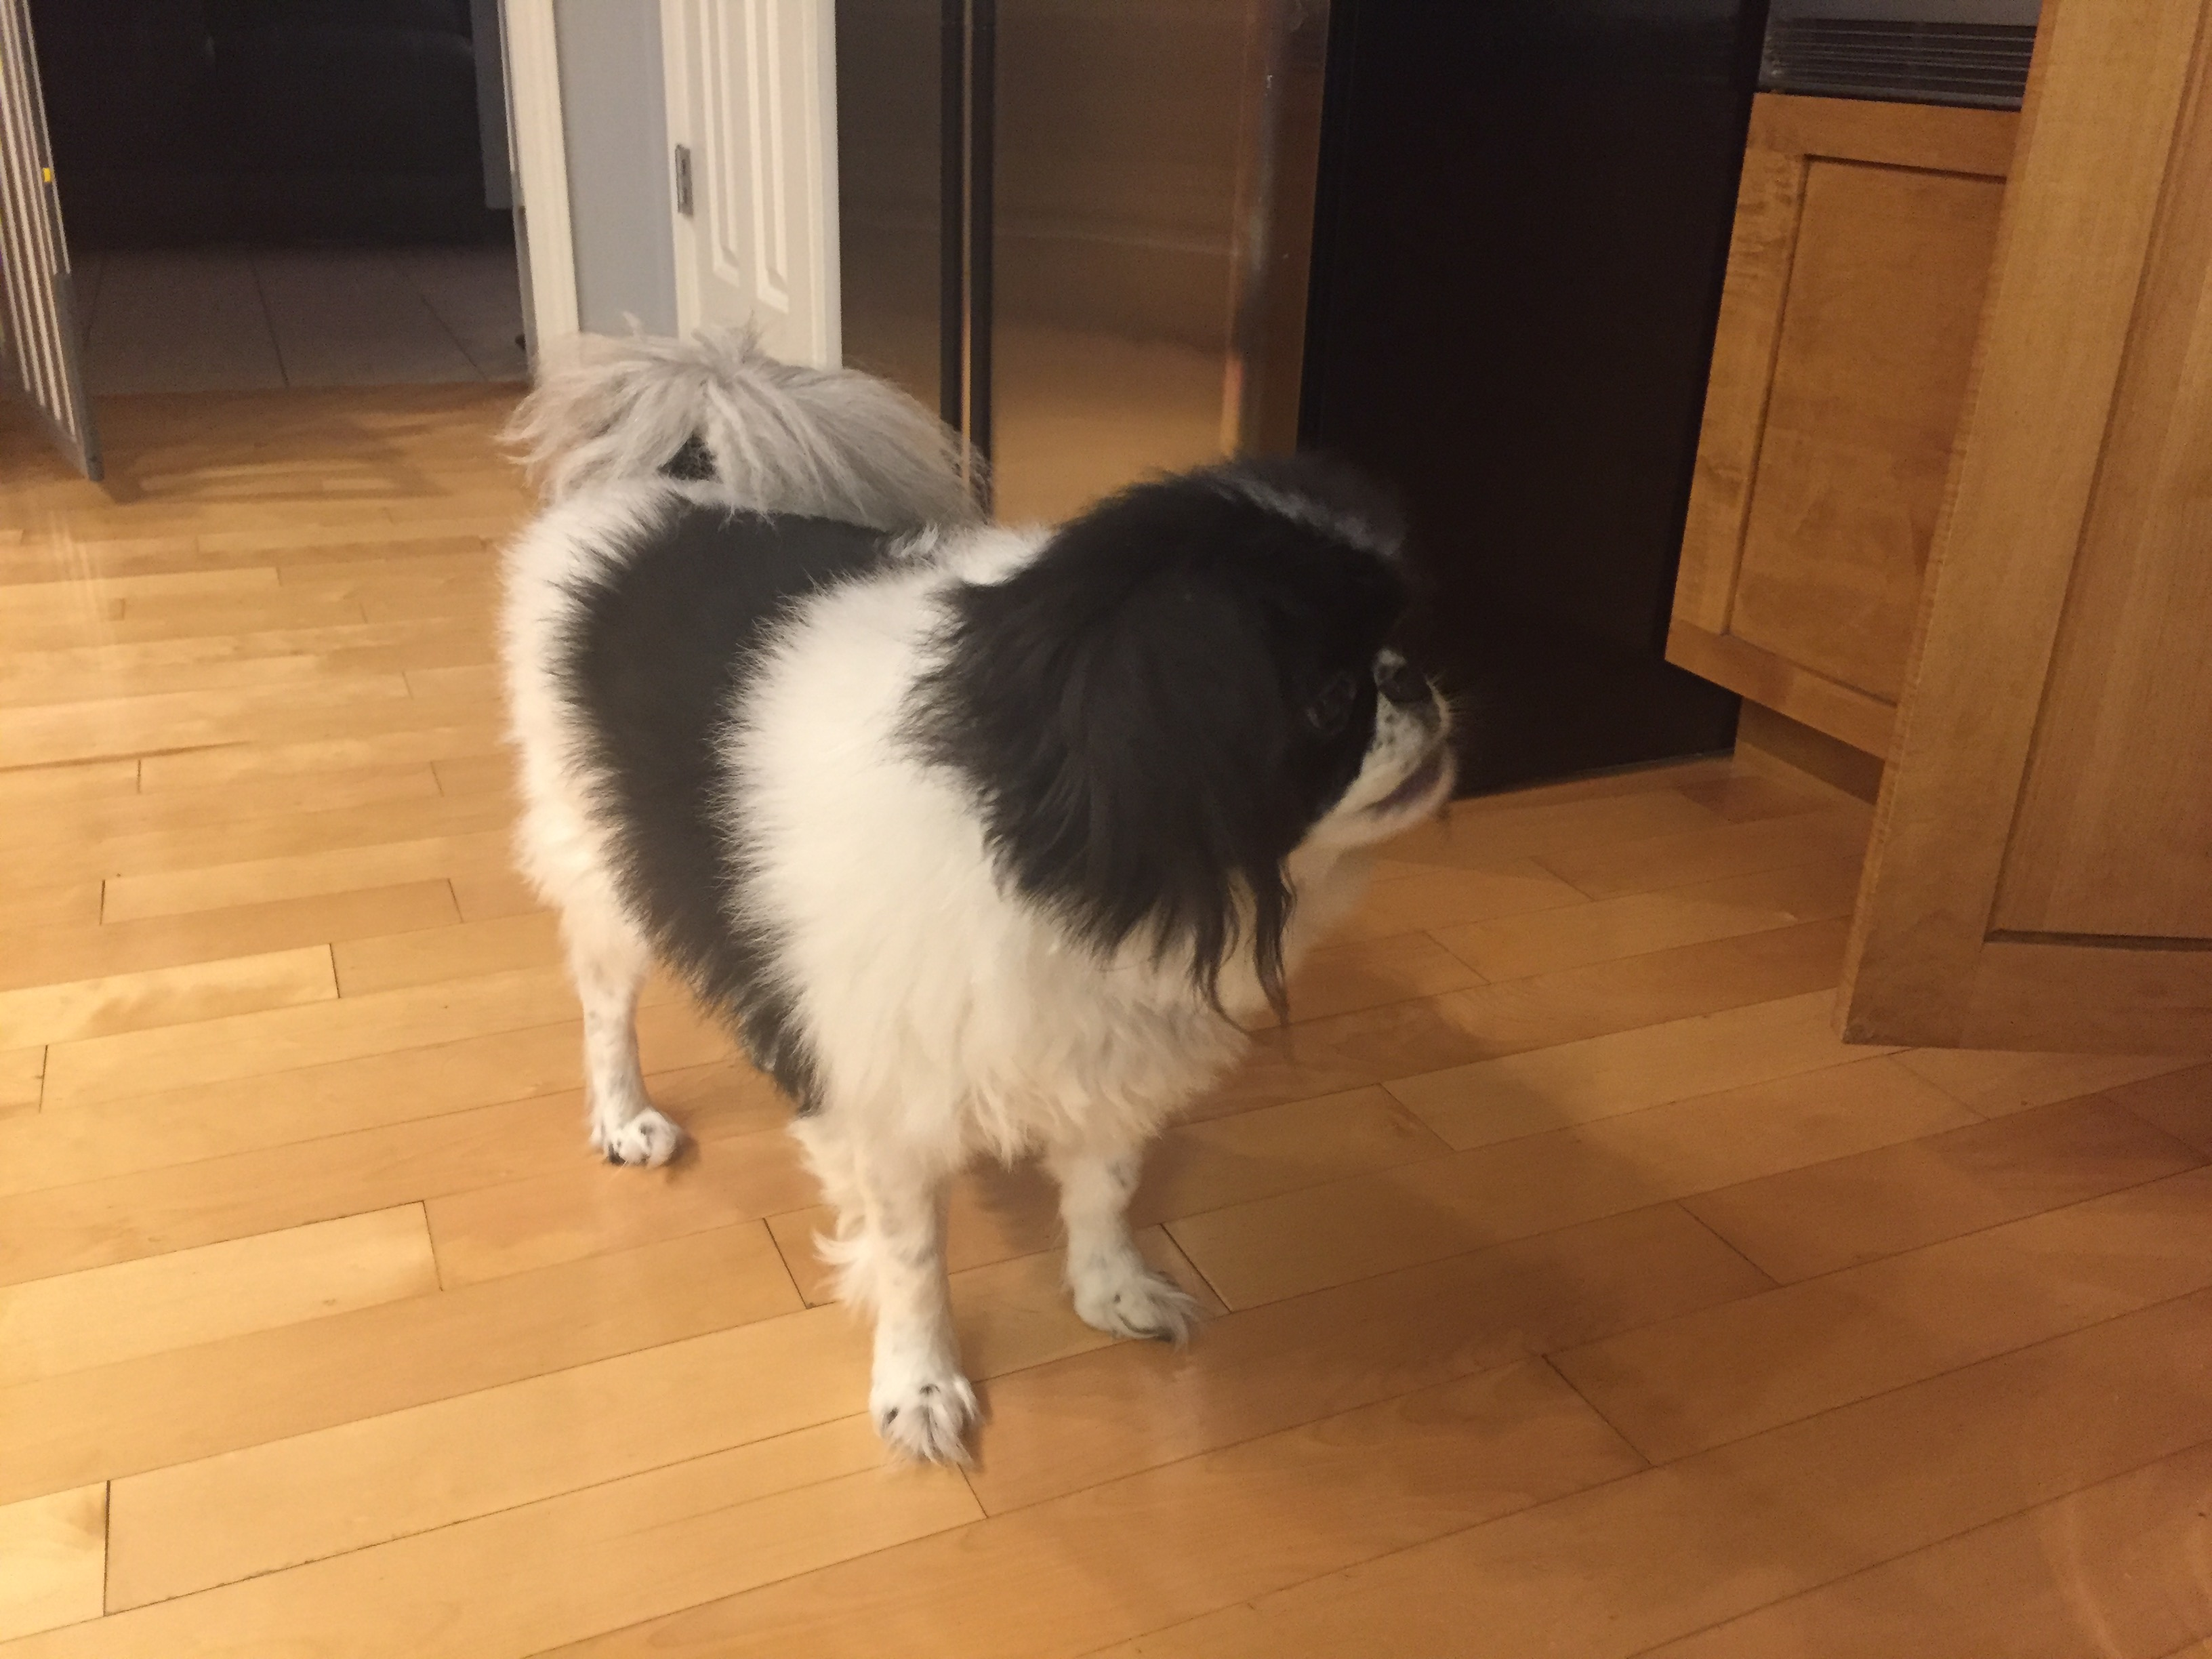

In [16]:
Image(filename='raj/huey.jpg') 

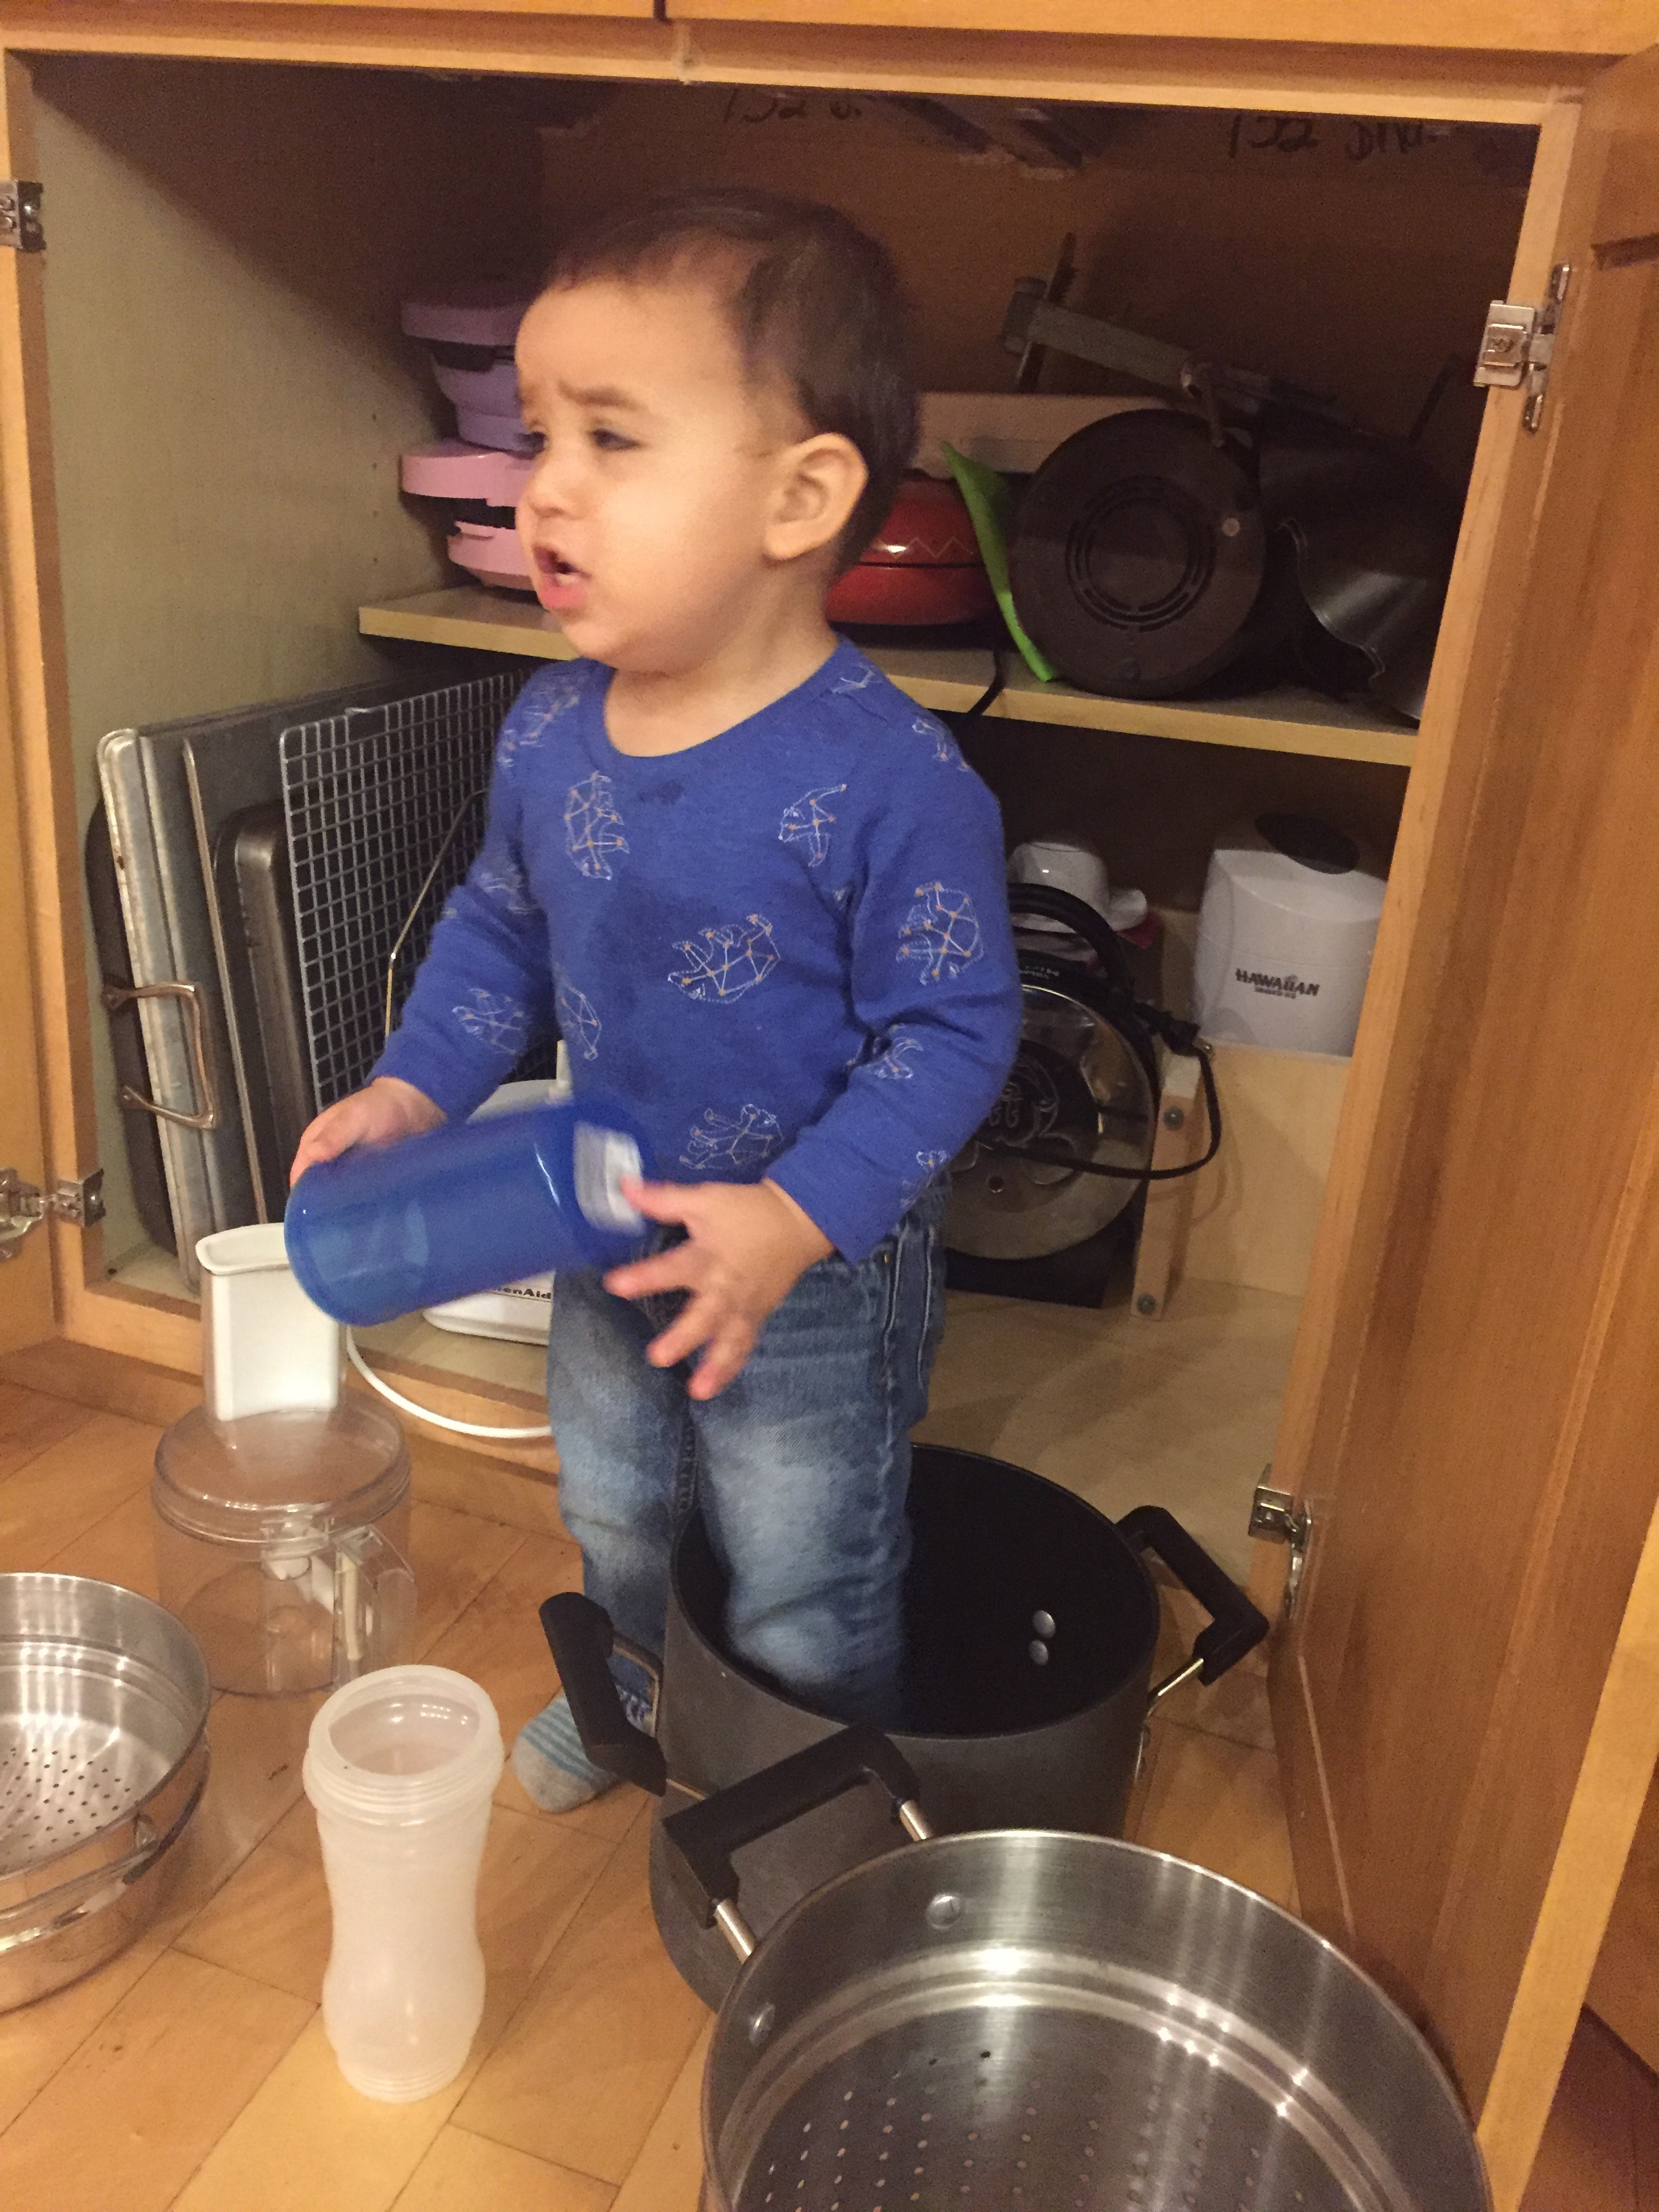

In [17]:
Image(filename='raj/vaylen.jpg')

In [ ]:
##Need to get prediction working
img = load_img('raj/alice.jpg',False, (img_width, img_height))
x = img_to_array(img)
prediction = model.predict(x.reshape((1,img_width, img_height,3)),batch_size=32, verbose=0)
print(prediction)

### Visualizing a Convolutional Neural Network

### Evaluating on validation set

In [ ]:
# Using quiver
#!pip install quiver_engine

In [ ]:
from keras.applications.vgg16 import VGG16
model_vgg = VGG16(weights='imagenet', include_top=True)

In [ ]:
from quiver_engine import server
#server.launch(model_vgg,input_folder='./raj')

Computing loss and accuracy :

In [11]:
model.evaluate_generator(validation_generator, validation_samples)

[1.6358572365178798, 0.72472205528846156]

Evolution of accuracy on training (blue) and validation (green) sets for 1 to 32 epochs :

![Accuracy evolution](pictures/scores_no_dataaugmentation.png)

**After ~10 epochs the neural network reach ~70% accuracy. We can witness overfitting, no progress is made over validation set in the next epochs**

## Data augmentation for improving the model

By applying random transformation to our train set, we artificially enhance our dataset with new unseen images.  
This will hopefully reduce overfitting and allows better generalization capability for our network.

Example of data augmentation applied to a picture:
![Example of data augmentation applied to a picture](pictures/cat_data_augmentation.png)

In [7]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2048 images belonging to 2 classes.


In [8]:
##Lets look at the training data
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  

i = 0
for batch in train_datagen_augmented.flow(x,batch_size=1,
                          save_to_dir='preview', save_prefix='aug2', save_format='jpg'):
    i += 1
    if i > 5:
        break  #

In [9]:
!ls preview

aug2_0_125.jpg	  train_10_2638.jpg  train_1_6767.jpg	train_4_3297.jpg
aug2_0_1805.jpg   train_10_3001.jpg  train_17_2432.jpg	train_4_3753.jpg
aug2_0_1983.jpg   train_11_4831.jpg  train_17_5031.jpg	train_5_2054.jpg
aug2_0_2253.jpg   train_11_6773.jpg  train_1_75.jpg	train_5_6591.jpg
aug2_0_3107.jpg   train_12_1168.jpg  train_18_8046.jpg	train_6_6153.jpg
aug2_0_4003.jpg   train_12_9061.jpg  train_18_8431.jpg	train_6_8550.jpg
aug2_0_6103.jpg   train_13_3936.jpg  train_19_6181.jpg	train_7_6307.jpg
aug2_0_6544.jpg   train_13_737.jpg   train_19_9408.jpg	train_7_8120.jpg
aug2_0_7307.jpg   train_14_3427.jpg  train_20_7450.jpg	train_8_2649.jpg
aug2_0_8106.jpg   train_14_7598.jpg  train_20_7602.jpg	train_8_3558.jpg
aug2_0_81.jpg	  train_15_3216.jpg  train_2_1654.jpg	train_9_3911.jpg
aug2_0_8474.jpg   train_15_5589.jpg  train_2_8433.jpg	train_9_5143.jpg
train_0_5372.jpg  train_16_172.jpg   train_3_2508.jpg
train_0_7289.jpg  train_16_3743.jpg  train_3_3853.jpg


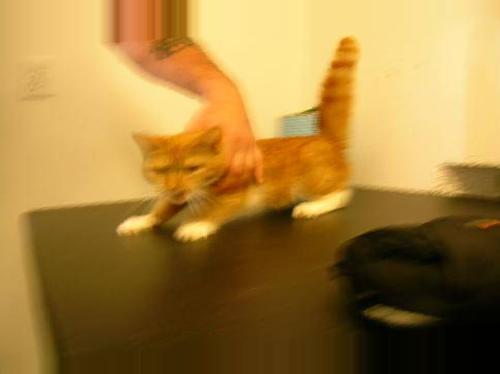

In [10]:
Image(filename='preview/aug2_0_125.jpg') 

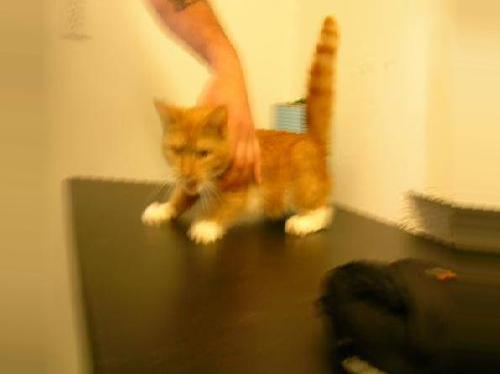

In [11]:
Image(filename='preview/aug2_0_2253.jpg')

In [13]:
model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/30
64/64 [==============================] - 8s - loss: 0.6181 - acc: 0.7075 - val_loss: 0.5214 - val_acc: 0.7296
Epoch 2/30
64/64 [==============================] - 7s - loss: 0.5563 - acc: 0.7510 - val_loss: 0.5814 - val_acc: 0.7224
Epoch 3/30
64/64 [==============================] - 7s - loss: 0.4982 - acc: 0.7700 - val_loss: 0.6890 - val_acc: 0.7188
Epoch 4/30
64/64 [==============================] - 7s - loss: 0.5247 - acc: 0.7583 - val_loss: 0.5678 - val_acc: 0.7115
Epoch 5/30
64/64 [==============================] - 7s - loss: 0.4814 - acc: 0.7871 - val_loss: 0.5177 - val_acc: 0.7776
Epoch 6/30
64/64 [==============================] - 7s - loss: 0.4932 - acc: 0.7900 - val_loss: 0.5102 - val_acc: 0.7873
Epoch 7/30
64/64 [==============================] - 7s - loss: 0.4770 - acc: 0.8013 - val_loss: 0.4926 - val_acc: 0.7668
Epoch 8/30
64/64 [==============================] - 7s - loss: 0.4402 - acc: 0.8008 - val_loss: 0.5014 - val_acc: 0.7728
Epoch 9/30
64/64 [==============

In [14]:
model.save_weights('models/augmented_30_epochs.h5')

In [15]:
#model.load_weights('models_trained/augmented_30_epochs.h5')

### Evaluating on validation set

Computing loss and accuracy :

In [15]:
model.evaluate_generator(validation_generator, validation_samples)

[0.57709803022086048, 0.76551231971153844]

Evolution of accuracy on training (blue) and validation (green) sets for 1 to 100 epochs :

![Accuracy evolution](pictures/scores_with_dataaugmentation.png)

**Thanks to data-augmentation, the accuracy on the validation set improved to ~80%**

## Using a pre-trained model

The process of training a convolutionnal neural network can be very time-consuming and require a lot of datas.  

We can go beyond the previous models in terms of performance and efficiency by using a general-purpose, pre-trained image classifier.  This example uses VGG16, a model trained on the ImageNet dataset - which contains millions of images classified in 1000 categories. 

On top of it, we add a small multi-layer perceptron and we train it on our dataset.

### VGG16 + small MLP
![VGG16 + Dense layers Schema](pictures/vgg16_original.png)

#### VGG16 model is available in Keras

In [18]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

### Using the VGG16 model to process samples

In [20]:
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 2048 images belonging to 2 classes.
Found 832 images belonging to 2 classes.


This is a long process, so we save the output of the VGG16 once and for all.  

In [21]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
np.save(open('models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [22]:
bottleneck_features_validation = model_vgg.predict_generator(validation_generator_bottleneck, validation_samples // batch_size)
np.save(open('models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Now we can load it...

In [23]:
train_data = np.load(open('models/bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))

validation_data = np.load(open('models/bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

And define and train the custom fully connected neural network :

In [24]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model_top.fit(train_data, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_data, validation_labels))

Train on 2048 samples, validate on 832 samples
Epoch 1/30
2048/2048 [==============================] - 0s - loss: 3.3870 - acc: 0.6279 - val_loss: 0.3765 - val_acc: 0.8173
Epoch 2/30
2048/2048 [==============================] - 0s - loss: 0.4014 - acc: 0.8232 - val_loss: 0.2767 - val_acc: 0.8990
Epoch 3/30
2048/2048 [==============================] - 0s - loss: 0.3015 - acc: 0.8784 - val_loss: 0.2481 - val_acc: 0.8882
Epoch 4/30
2048/2048 [==============================] - 0s - loss: 0.2591 - acc: 0.8931 - val_loss: 0.4684 - val_acc: 0.8281
Epoch 5/30
2048/2048 [==============================] - 0s - loss: 0.2334 - acc: 0.9048 - val_loss: 0.2334 - val_acc: 0.9062
Epoch 6/30
2048/2048 [==============================] - 0s - loss: 0.2005 - acc: 0.9224 - val_loss: 0.2395 - val_acc: 0.9026
Epoch 7/30
2048/2048 [==============================] - 0s - loss: 0.1791 - acc: 0.9233 - val_loss: 0.6955 - val_acc: 0.7849
Epoch 8/30
2048/2048 [==============================] - 0s - loss: 0.1490 - ac

The training process of this small neural network is very fast : ~2s per epoch

In [26]:
model_top.save_weights('models/bottleneck_30_epochs.h5')

### Bottleneck model evaluation

In [26]:
#model_top.load_weights('models/bottleneck_30_epochs.h5)

Loss and accuracy :

In [27]:
model_top.evaluate(validation_data, validation_labels)

800/832 [===========================>..] - ETA: 0s

[0.54362334619061303, 0.91225961538461542]

Evolution of accuracy on training (blue) and validation (green) sets for 1 to 32 epochs :

![Accuracy evolution](pictures/scores_with_bottleneck.png)

**We reached a 90% accuracy on the validation after ~1m of training (~20 epochs) and 8% of the samples originally available on the Kaggle competition !**

## Fine-tuning the top layers of a a pre-trained network

Start by instantiating the VGG base and loading its weights.

In [28]:
model_vgg = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

Build a classifier model to put on top of the convolutional model. For the fine tuning, we start with a fully trained-classifer. We will use the weights from the earlier model. And then we will add this model on top of the convolutional base.

In [31]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.load_weights('models/bottleneck_40_epochs.h5')

#model_vgg.add(top_model)
model = Model(inputs = model_vgg.input, outputs = top_model(model_vgg.output))

For fine turning, we only want to train a few layers.  This line will set the first 25 layers (up to the conv block) to non-trainable.

In [32]:
for layer in model_vgg.layers[:15]:
    layer.trainable = False

In [33]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [34]:
# prepare data augmentation configuration  . . . do we need this?
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

Found 2048 images belonging to 2 classes.
Found 832 images belonging to 2 classes.


In [35]:
# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

Epoch 1/30
64/64 [==============================] - 14s - loss: 0.3143 - acc: 0.8945 - val_loss: 0.3477 - val_acc: 0.9123
Epoch 2/30
64/64 [==============================] - 14s - loss: 0.1789 - acc: 0.9336 - val_loss: 0.2682 - val_acc: 0.9243
Epoch 3/30
64/64 [==============================] - 14s - loss: 0.1597 - acc: 0.9404 - val_loss: 0.2590 - val_acc: 0.9267
Epoch 4/30
64/64 [==============================] - 14s - loss: 0.1227 - acc: 0.9561 - val_loss: 0.3725 - val_acc: 0.9050
Epoch 5/30
64/64 [==============================] - 14s - loss: 0.1375 - acc: 0.9492 - val_loss: 0.3094 - val_acc: 0.9062
Epoch 6/30
64/64 [==============================] - 14s - loss: 0.0917 - acc: 0.9678 - val_loss: 0.2808 - val_acc: 0.9159
Epoch 7/30
64/64 [==============================] - 14s - loss: 0.1110 - acc: 0.9595 - val_loss: 0.3092 - val_acc: 0.9171
Epoch 8/30
64/64 [==============================] - 14s - loss: 0.1013 - acc: 0.9653 - val_loss: 0.3118 - val_acc: 0.9147
Epoch 9/30
64/64 [======

In [36]:
model.save_weights('models/finetuning_30epochs_vgg.h5')

In [38]:
model.load_weights('models/finetuning_30epochs_vgg.h5')

### Evaluating on validation set

Computing loss and accuracy :

In [37]:
model.evaluate_generator(validation_generator, validation_samples)

[0.33350689638357905, 0.93280498798076927]